# Notebook for detecting multi-resolution clonal structures

This notebook reproduces the plots found in the accompanying paper, and loads parameters from a cached output file. Experiments can be re-produced using the scripts found in the above directory. This will also generate additional run-time plots using WandB logging callbacks.

In [1]:
import numpy as np
import pickle as pkl
import torch
import pandas as pd
from IPython.display import display, HTML
import umap
from sklearn.manifold import TSNE
from sklearn.cluster import SpectralBiclustering
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import style
import palettable
from palettable.colorbrewer.qualitative import Set1_6 as pallette

import TCGA
from WaveletVAE.src.WaveLSTM.models.base import WaveletBase

sns.set()
sns.set_palette(pallette.mpl_colors)

Global seed set to 42
Global seed set to 42
Global seed set to 42


# Get data

In [2]:
dm = TCGA.data_modules.CHISEL_S0E.loaders.DataModule(batch_size=32, sampler=False, chr_length=256)

data = []
for loader in [dm.train_dataloader(), dm.val_dataloader(), dm.test_dataloader()]:
    features, labels = [], []
    for batch in iter(loader):
        features.append(batch["feature"])
        labels.append(batch["label"])
    data.append({"feature": torch.concat(features, 0).numpy().reshape((-1, 2, 22, 256)),
                 "label": torch.concat(labels, 0).numpy()}
               )
    
cluster_names = ["Clone " + i for i in ["I", "II", "III", "IV", "V", "VI"]]
print(cluster_names)

['Clone I', 'Clone II', 'Clone III', 'Clone IV', 'Clone V', 'Clone VI']


In [3]:
# Report counts and order labels
label_order = []
splits = []
for data_set, data_split in zip(["Training set", "Validation set", "Test set"], data):
    print(f"\n{data_set}\n==================")
    print(f"{data_split['feature'].shape[0]} samples composed of")
    
    split = [0.5]
    for lbl, cnt in zip(*np.unique(data_split['label'], return_counts=True)):
        split.append(cnt)
        print(f"{cluster_names[lbl]} with count {cnt}")
    splits.append(np.cumsum(split))

    label_order.append(np.argsort(data_split["label"]))



Training set
1158 samples composed of
Clone I with count 310
Clone II with count 136
Clone III with count 41
Clone IV with count 17
Clone V with count 630
Clone VI with count 24

Validation set
145 samples composed of
Clone I with count 42
Clone II with count 17
Clone III with count 9
Clone IV with count 1
Clone V with count 73
Clone VI with count 3

Test set
145 samples composed of
Clone I with count 38
Clone II with count 15
Clone III with count 8
Clone IV with count 2
Clone V with count 79
Clone VI with count 3


## Visualise each set's channel's and strands

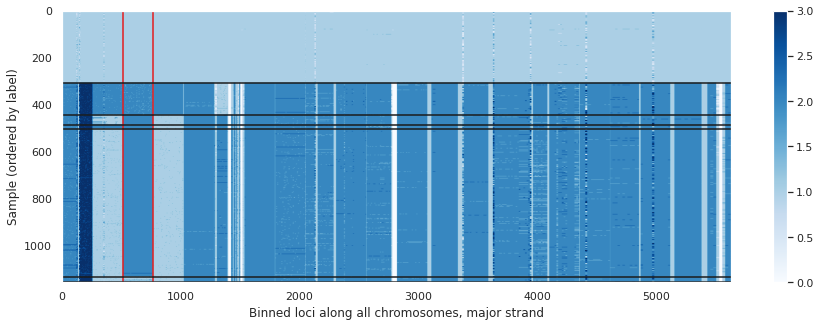

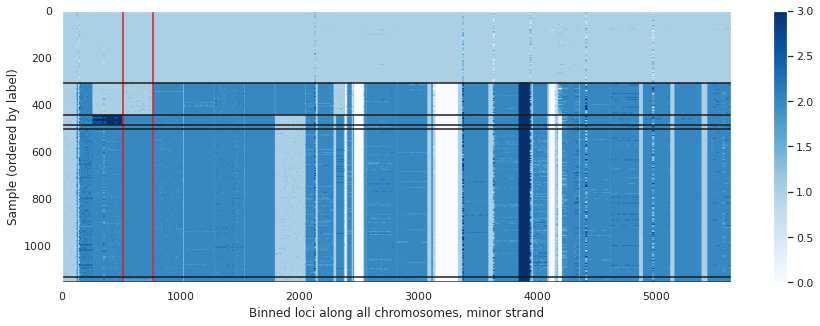

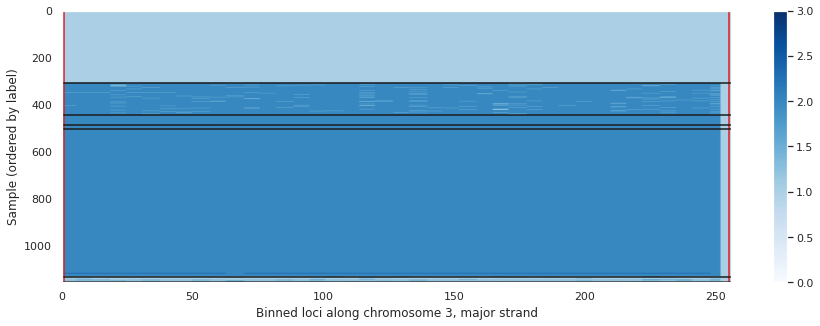

In [4]:
subset = 0           # Training set = 0, Validation set = 1, Test set = 2

# Individual channel and strand
chromosome = 3       # 1,...,22
strand = 1           # 1 or 2

# Stacked channels
for _strand in range(1,3):
    plt.figure(figsize=(15, 5))
    tmp = data[subset]["feature"][label_order[subset], _strand-1, :, :].reshape((-1, 22*256))
    plt.imshow(tmp, aspect='auto', cmap="Blues", vmin=0, vmax=3)
    plt.axvline(x=(chromosome-1)*dm.W)
    plt.axvline(x=(chromosome)*dm.W)
    for split in splits[subset]:
        plt.axhline(y=split, color='k', linestyle='-')
    plt.ylim((splits[subset][-1], 0, ))
    plt.ylabel("Sample (ordered by label)")
    plt.xlabel(f"Binned loci along all chromosomes, {'major' if _strand == 1 else 'minor'} strand")
    plt.colorbar()
    plt.grid(False)
    plt.show()



plt.figure(figsize=(15, 5))
plt.imshow(data[subset]["feature"][label_order[subset], strand-1, chromosome-1, :], aspect='auto', cmap="Blues", vmin=0, vmax=3)
plt.axvline(x=1)
plt.axvline(x=dm.W-1)
for split in splits[subset]:
    plt.axhline(y=split, color='k', linestyle='-')
plt.ylim((splits[subset][-1], 0, ))
plt.ylabel("Sample (ordered by label)")
plt.xlabel(f"Binned loci along chromosome {chromosome}, {'major' if strand == 1 else 'minor'} strand")
plt.xlim((0,dm.W))
plt.colorbar()
plt.grid(False)
plt.show()

## Due to class imbalance, plot the first 10 of each clone to see more clearly

There are still variations within each clone

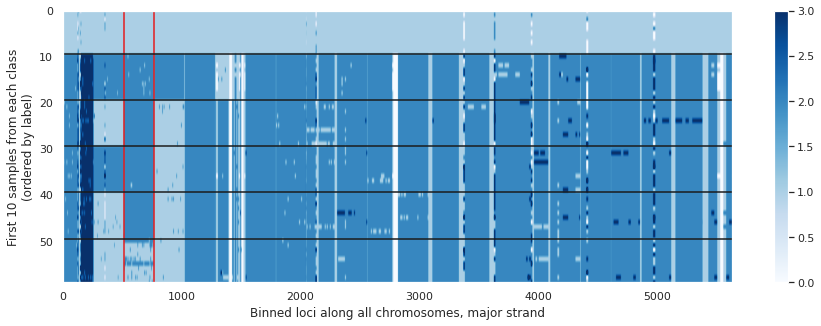

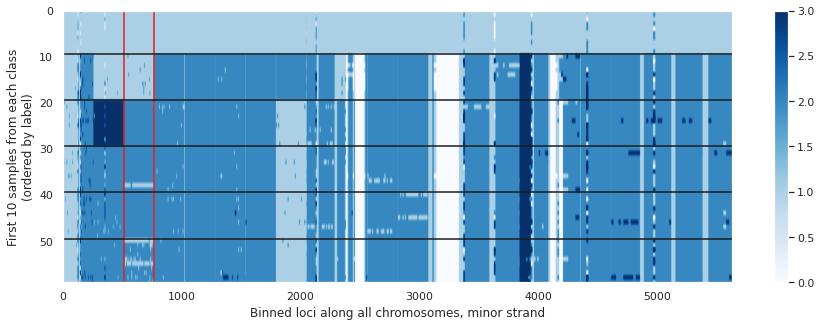

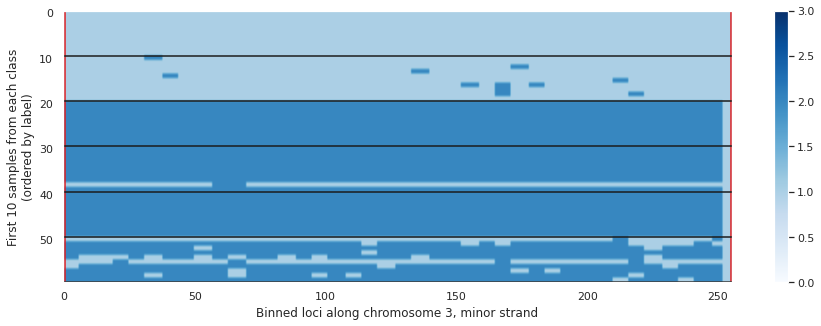

In [5]:
# Individual channel and strand
chromosome = 3          # 1,...,22
strand = 0           # 1 or 2

top_k = [np.where(data[subset]["label"] == l)[0][:10] for l in range(6)]
top_6k = np.concatenate(top_k, 0)

for _strand in range(1,3):
    # Stacked channels
    plt.figure(figsize=(15, 5))
    tmp = data[subset]["feature"][top_6k, _strand-1, :, :].reshape((-1, 22*256))
    plt.imshow(tmp, aspect='auto', cmap="Blues", vmin=0, vmax=3)
    plt.axvline(x=(chromosome-1)*dm.W);   plt.axvline(x=(chromosome)*dm.W)
    for split in range(0,70,10):
        plt.axhline(y=split-0.5, color='k', linestyle='-')
    plt.ylim((59, 0, ))
    plt.ylabel("First 10 samples from each class\n(ordered by label)")
    plt.xlabel(f"Binned loci along all chromosomes, {'major' if _strand == 1 else 'minor'} strand")
    plt.colorbar()
    plt.grid(False)
    plt.show()


plt.figure(figsize=(15, 5))
plt.imshow(data[subset]["feature"][top_6k, strand-1, chromosome-1, :], aspect='auto', cmap="Blues", vmin=0, vmax=3)
plt.axvline(x=0.5)
plt.axvline(x=dm.W-1)
for split in range(0,70,10):
    plt.axhline(y=split-0.5, color='k', linestyle='-')
plt.ylabel("First 10 samples from each class\n(ordered by label)")
plt.xlabel(f"Binned loci along chromosome {chromosome}, {'major' if strand == 1 else 'minor'} strand")
plt.colorbar()
plt.grid(False)
plt.show()

From top to bottom. 

* Clone I, a diploid clone comprised of mostly normal cells, is clearly distinguishable.
* Clone II
* Clone III
* Clone IV
* Clone V
* Clone VI most notably has a deletion on chromosome 3 of the major strand, or an insertion on chromosome 3 of the minor strand. Particularly on the minor strand, this characteristic is shared with other clones.

# Model visualisations

Additional visualisation are provided at run-time with WandB logging callbacks.



Attentive autoencoder:

    Channelised chromosomes
         J=4
         "../logs/a-ae-output_j4_nostack_noproj.pkl"             # No recurrent projection
         "../logs/a-ae-output_j4_nostack_proj64.pkl"             # Recurrent projection to 64 dimensions
     Stacked chromosomes
         J=5
         "../logs/a-ae-output_j5_stack_proj64.pkl"
         "../logs/a-ae-output_j8_stack_noproj.pkl"
         J=8
         "../logs/a-ae-output_j8_stack_proj64.pkl"


Replace log file to view the same plots for other model types

In [65]:
model_name = "j8_stack_noproj"

with open(f"../logs/a-ae-output_{model_name}.pkl", 'rb') as file:
    meta_results = pkl.load(file)

# wave-LSTM outputs    
J = len(meta_results["resolution_embeddings"])
lbls = meta_results["labels"].cpu().numpy()
Mbar = torch.mean(meta_results["M"], axis=1).cpu().numpy()
Mflat = torch.flatten(meta_results["M"], start_dim=1).cpu().numpy()
A = meta_results["attention"]
print(f"Available outputs: {meta_results.keys()}")


Available outputs: dict_keys(['masked_inputs', 'masked_targets', 'resolution_embeddings', 'attention', 'M', 'masked_predictions', 'labels'])


# Visualise Wave-LSTM encoder output

In [66]:
# First, just create instance of whatever reducer we want to use

reduce_method = "tSNE"         # tSNE or umap

if reduce_method.lower() == "umap":
    reducer = umap.UMAP()
elif reduce_method.lower() == "tsne":
    reducer = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=20)
else:
    raise NotImplementedError

# axis labels
latent1 = f"{reduce_method}-1"
latent2 = f"{reduce_method}-2"

### Resolution-embeddings (vs. source-separated inputs)

We visualise the learnt $h_j$, and compare how this differs from source-separated input $X_j$. 

In [67]:
data_emb = []
for j_res, j_name in zip([i for i in range(J)], [f"{j+1}" for j in range(J)]): 

    h_j = meta_results["resolution_embeddings"][j_res].cpu().numpy()
    x_j = meta_results["masked_inputs"][j_res].cpu().numpy()

    # Projection of scale embeddings, and source separated input
    for val, val_name in zip([h_j, x_j], ["h_j", "X_j"]):

        val = val.reshape((val.shape[0], -1))           # Reshape x_j to flatten channels
        val = StandardScaler().fit_transform(val)       # Scale before any transform
        
        embedding = reducer.fit_transform(val)
        for i in range(embedding.shape[0]):
            data_emb.append([i, 
                             embedding[i, 0], embedding[i, 1], 
                             val_name,
                             j_name, cluster_names[lbls[i]],
                            ])  

df_emb = pd.DataFrame(data_emb, columns=["sample", latent1, latent2, "source", "resolution", "Class"])
display(df_emb)

,sample,tSNE-1,tSNE-2,source,resolution,Class
0,0,6.891884,9.834809,h_j,1,Clone V
1,1,-5.090658,-34.671707,h_j,1,Clone I
2,2,-1.462462,2.555414,h_j,1,Clone III
3,3,1.364874,5.484440,h_j,1,Clone V
4,4,-3.677845,14.516444,h_j,1,Clone V
...,...,...,...,...,...,...
2315,140,-1.002358,-23.772535,X_j,8,Clone I
2316,141,-1.543384,14.846425,X_j,8,Clone V
2317,142,-0.709841,-24.755880,X_j,8,Clone I
2318,143,1.266166,14.702287,X_j,8,Clone V


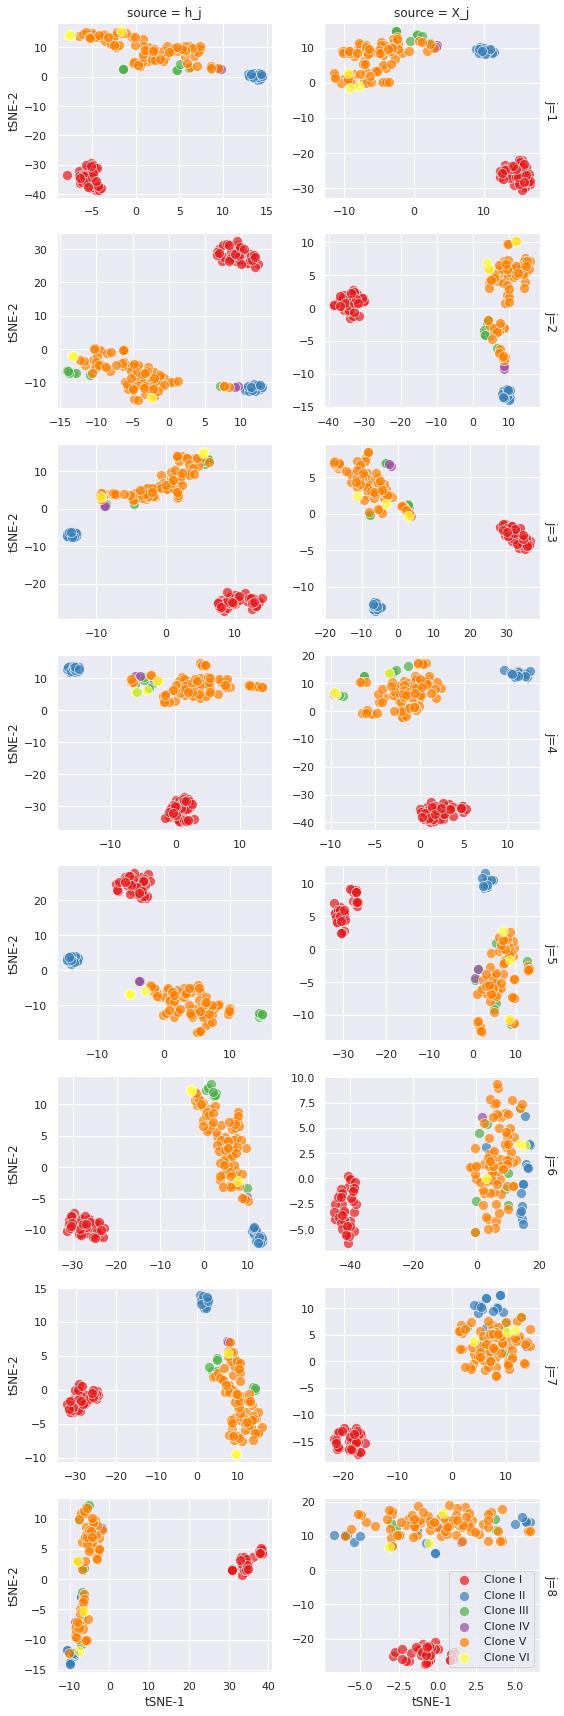

In [68]:
# df_emb = df_emb[df_emb["Class"].isin(["Clone III", "Clone IV", "Clone V", "Clone VI"])]


# Plot
g = sns.FacetGrid(df_emb, row="resolution", col="source", hue="Class", hue_order=cluster_names, 
                  margin_titles=True, despine=False, height=3, aspect=4/3, sharex=False, sharey=False)
g.map(sns.scatterplot, latent1, latent2, alpha=0.7, s=100, legend="auto")
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)
g.set_titles(row_template="j={row_name}")
plt.legend(loc='best')
plt.show()

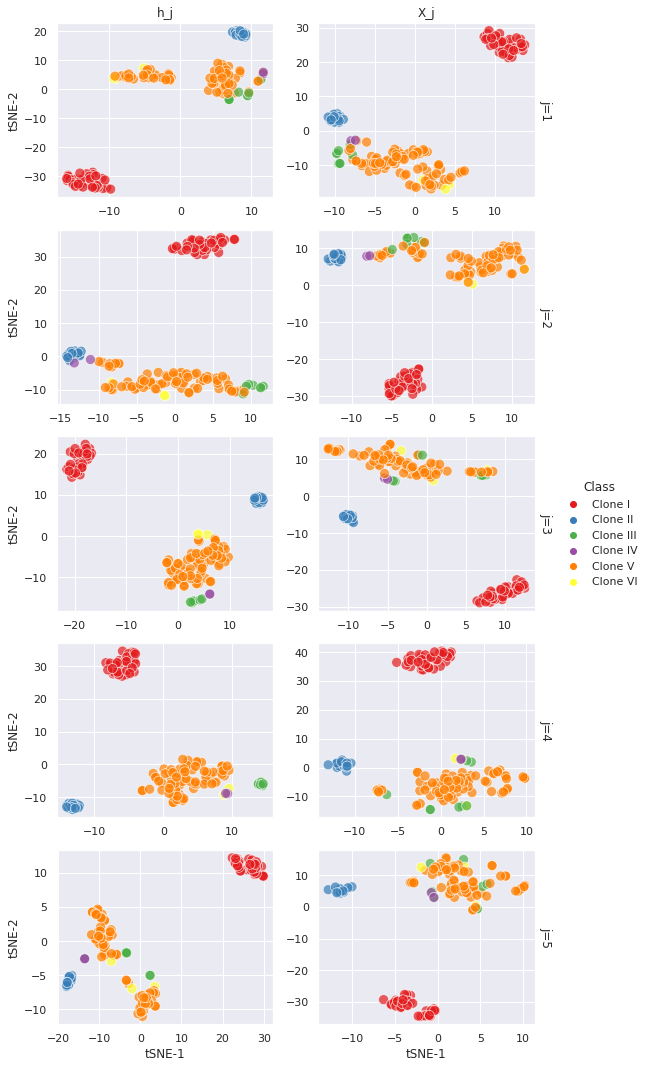

In [63]:
g = sns.relplot(data=df_emb, x=latent1, y=latent2,  row="resolution", col="source", hue="Class",  hue_order=cluster_names,
                legend="auto", s=100, alpha=0.7,
                height=3, aspect=4/3,
                palette="Set1",
                facet_kws={'sharey': False, 'sharex': False, 'margin_titles': True, 'despine': False,}
               )
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)
g.set_titles(row_template="j={row_name}", col_template="{col_name}")
plt.show()

We find that $h_j$ benefits from the information flow through the LSTM model. Embeddings are improved by

* the additional label/task information, leading to adaptive filtering.
* the ability of the LSTM model to pass information through the recurrent cell states. E.g. Whilst the orange class was separable at $X_{j=4}$, and subsequently not - within the resolution embeddings that information has been retained for $h_{j\geq4}$. Note, this behaviour can be controlled through reducing and increasing the capacity of the hidden states.


## Visualisation of self-attention

We can also visualise the learnt self-attention, allowing us to see which resolutions the model thought were predictive.

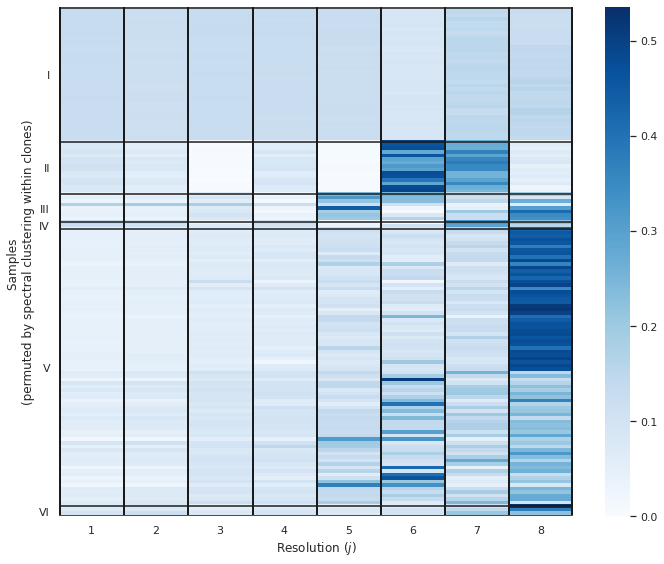

In [47]:
num_spectral_clusters = 2

# Order samples by label
permute_idx = np.argsort(lbls)
ord_lbls = lbls[permute_idx]
ord_attention = A[permute_idx, :, :]

# average over attention hops:   [batch_size, num_multiscales]
ord_attention = torch.mean(ord_attention, dim=1).cpu().numpy()  

# Nested ordering (by biclustering attention)
attention_new = np.zeros_like(ord_attention)
for _lbl in np.unique(ord_lbls):
    lbl_idx = np.where(ord_lbls == _lbl)[0]
    atn_cls = ord_attention[lbl_idx, :]
    biclustering = SpectralBiclustering(n_clusters=(np.min((num_spectral_clusters,atn_cls.shape[0])), 1),
                                        method="log", random_state=0)
    biclustering.fit(atn_cls)
    atn_cls = atn_cls[np.argsort(biclustering.row_labels_)]
    attention_new[lbl_idx, :]  = atn_cls#[:, np.argsort(biclustering.column_labels_)]
attention = attention_new


# Plot
fig, ax = plt.subplots(1, 1, figsize=(10,8))
sns.heatmap(attention, ax=ax, cmap='Blues', vmin=0, yticklabels=False)   # vmax=1

# Split clones
for split in splits[-1]:
    plt.axhline(y=split, color='k', linestyle='-')
ax.set_yticks((splits[-1][1:] + splits[-1][:-1])/2)
ax.set_yticklabels(["I", "II", "III", "IV", "V", "VI"])
ax.set_xticklabels([f"{j+1}" for j in range(J)], minor=False)    

# Split resolutions
for x_tick in [i for i in range(J)]:
    ax.vlines(x=x_tick+0.01, ymin=0, ymax=attention.shape[0], linewidth=2, color='k')
ax.vlines(x=attention.shape[1]-0.01, ymin=0, ymax=attention.shape[0], linewidth=2, color='k')

ax.set_xlabel("Resolution $(j)$")
ax.set_ylabel("Samples \n(permuted by spectral clustering within clones)")    # permuted
plt.ylim((splits[2][-1], 0, ))

plt.tight_layout()
plt.savefig(f"{model_name}/attention.png", dpi=500, format='png', transparent=False)

## Plot resolutions highlighted with self-attention


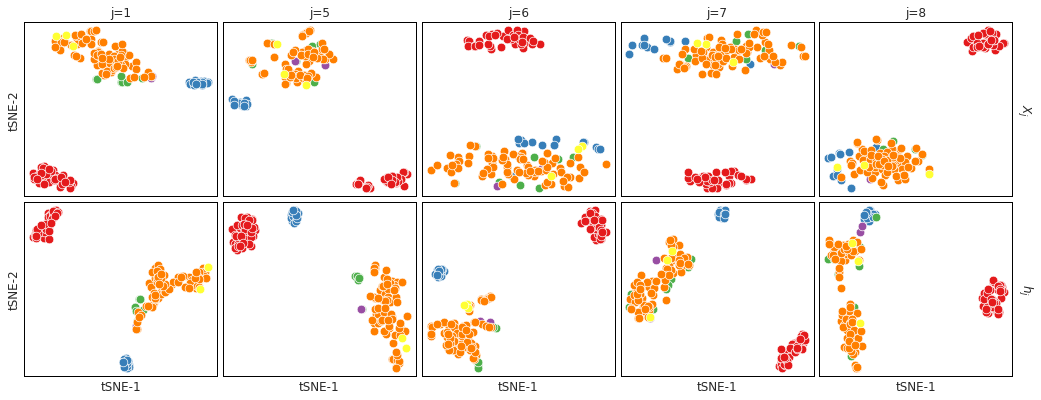

In [49]:
resolutions = [1,5,6,7,8]         # 1,2,3,...,J=4
sources = ["X_j", "h_j"]

df_emb_sub = df_emb[(df_emb["resolution"].isin([f"{i}" for i in resolutions])) & 
                    (df_emb["source"].isin(sources))
                   ]

g = sns.FacetGrid(df_emb_sub, col="resolution", row="source", hue="Class", hue_order=cluster_names,
                  row_order=sources,
                  margin_titles=True, despine=False, height=3, aspect=1, sharex=False, sharey=False)
g.map(sns.scatterplot, f"{reduce_method}-1", f"{reduce_method}-2", alpha=1, s=75)
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)

g.set_titles(col_template="j={col_name}", row_template="${row_name}$")    # {row_name}
    

g.set(xticks=[])
g.set(yticks=[])
g.set_xlabels(label=f"{reduce_method}-1", clear_inner=True, )
g.set_ylabels(label=f"{reduce_method}-2", clear_inner=True, )

for ax in g.axes.flatten():  
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)
        
    ax.set_facecolor((0, 0, 0, 0))

# plt.legend()
    
# Adjust margins
# plt.tight_layout()
g.figure.subplots_adjust(wspace=0.03, hspace=0.03)
# plt.gcf().set_size_inches(8, 3.5)
        
plt.savefig(f"{model_name}/resolution_embeddings2.png", dpi=500, format='png', transparent=False)

## Visualisation of the multi-resolution embedding

We can visualise the embedding tensor $M$ by either flattening, or taking the average across hops. For this example $r_{\text{hops}}=1$, and so they are equivalent.

In [77]:
data_mres_emb = []
for Mvar, Mname in zip([Mflat, Mbar], ["Mflat"]):

    embedding = reducer.fit_transform(Mvar.reshape((Mvar.shape[0], -1)))

    for i in range(embedding.shape[0]):
        data_mres_emb.append([i,
                              embedding[i, 0], embedding[i, 1], 
                              Mname,
                              cluster_names[lbls[i]]
                             ])  

df_mres_emb = pd.DataFrame(data_mres_emb, columns=["sample", latent1, latent2, "source", "Clone"])

display(df_mres_emb)

,sample,tSNE-1,tSNE-2,source,Clone
0,0,-4.054271,-10.455874,Mflat,Clone V
1,1,16.400782,22.930750,Mflat,Clone I
2,2,4.790637,-8.047719,Mflat,Clone III
3,3,-3.300835,-0.247986,Mflat,Clone V
4,4,-1.796757,1.539812,Mflat,Clone V
...,...,...,...,...,...
140,140,16.454084,21.413826,Mflat,Clone I
141,141,-3.490208,-11.172347,Mflat,Clone V
142,142,15.664288,20.549477,Mflat,Clone I
143,143,-3.680612,-0.332281,Mflat,Clone V


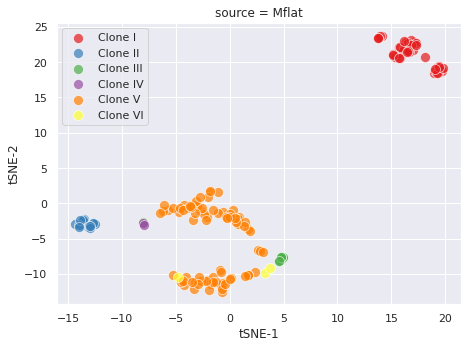

In [78]:
# Plot
g = sns.FacetGrid(df_mres_emb, col="source", hue="Clone", hue_order=cluster_names,
                  margin_titles=True, despine=False, height=5, aspect=4/3, sharex=False, sharey=False)
g.map(sns.scatterplot, latent1, latent2, alpha=0.7, s=100)
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)
plt.legend(loc="best")
plt.savefig(f"{model_name}/mresolution_embedding1.png", dpi=500, format='png', transparent=False)

## Plot flattened multi-resolution embeddings (in paper)

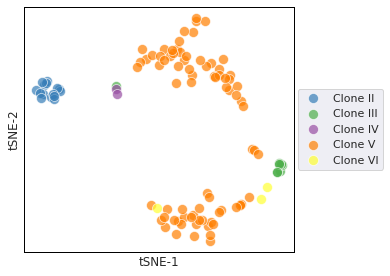

In [82]:
sources = ["Mflat"]

df_mres_emb = df_mres_emb[df_mres_emb["source"].isin(sources)]
df_mres_emb_healthy = df_mres_emb[df_mres_emb["Clone"].isin(["Clone I"])]
df_mres_emb_unhealthy = df_mres_emb[df_mres_emb["Clone"].isin(["Clone II", "Clone III", "Clone IV", "Clone V", "Clone VI"])]


g = sns.FacetGrid(df_mres_emb_unhealthy,  col="source", hue="Clone", hue_order=cluster_names,
                  margin_titles=True, despine=False, height=4, aspect=1.5, sharex=False, sharey=False)
g.map(sns.scatterplot, latent1, latent2, alpha=0.7, s=100)
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)

g.set_titles(col_template="", row_template="")    # {row_name}

g.set(xticks=[])
g.set(yticks=[])
g.set_xlabels(label=latent1, clear_inner=True, )
g.set_ylabels(label=latent2, clear_inner=True, )

for ax in g.axes.flatten():  
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)
        
    ax.set_facecolor((0, 0, 0, 0))

# Adjust margins
plt.legend(loc="center right", bbox_to_anchor=(1.35,0.5,0,0))
plt.tight_layout()

plt.savefig(f"{model_name}/mresolution_embedding2.png", dpi=500, format='png', transparent=False)

## Taking a look at how subsections of latent space look in feature space

i.e. what features are certain resolutions making distinctions upon.

### Resolution spaces

<ipython-input-15-cb0b02348ba0>:24: UserWarning:

Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.



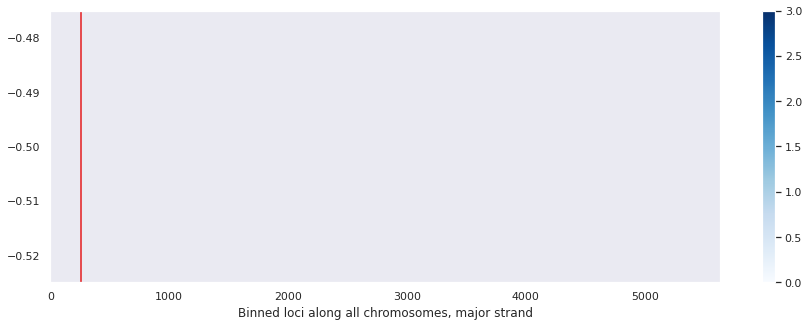

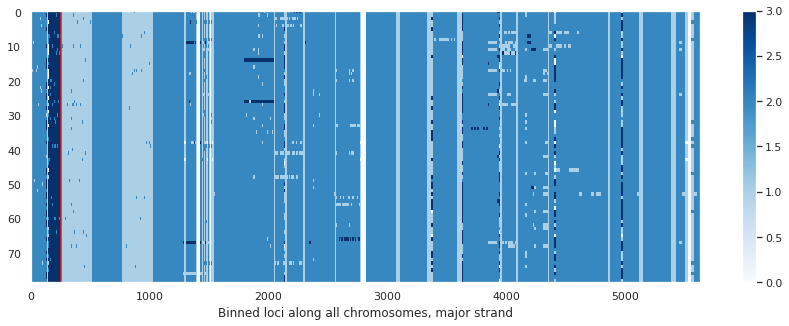

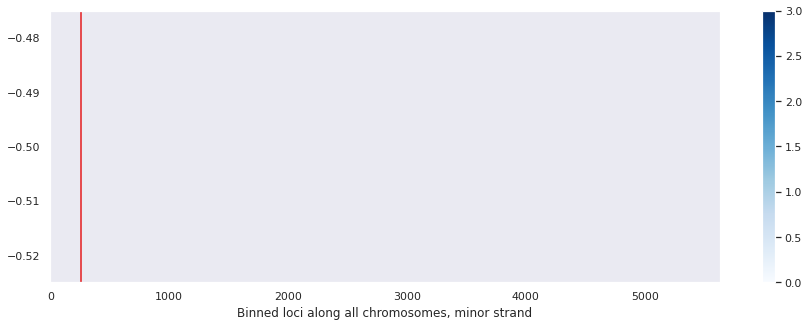

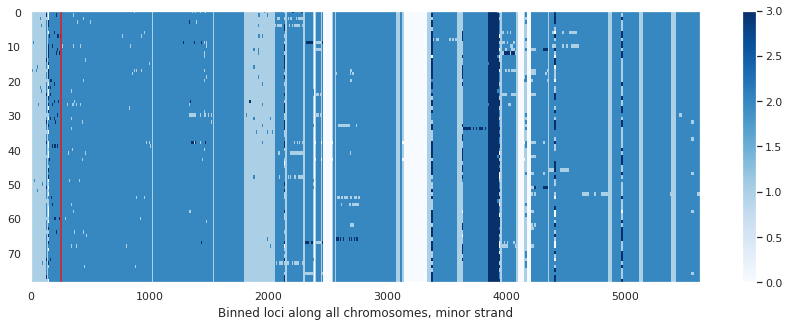

<ipython-input-15-cb0b02348ba0>:35: UserWarning:

Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.



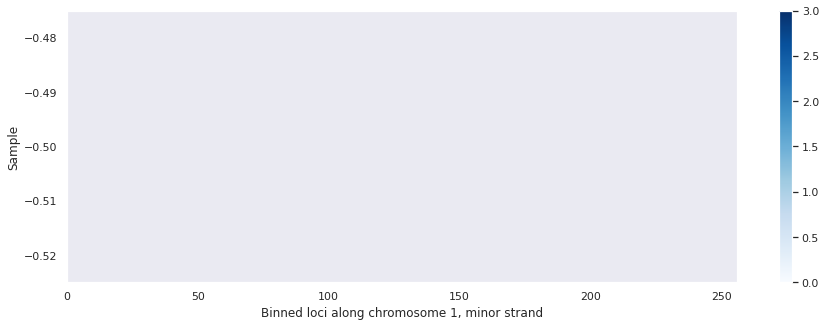

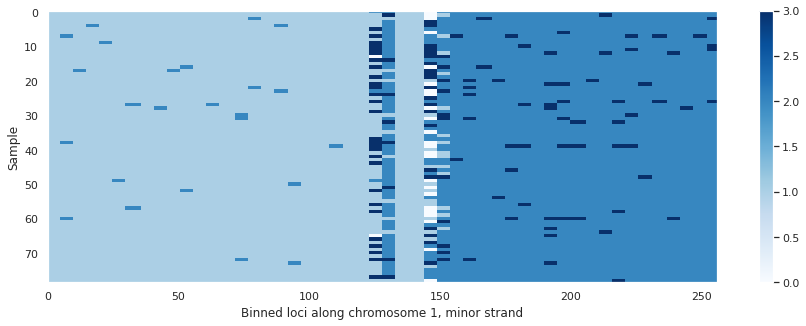

In [15]:
# display(df_emb)


# Individual channel and strand
chromosome = 1       # 1,...,22
strand = 2           # 1 or 2
resolution = 4

# Change query to see other subsections
ind1 = df_emb.loc[(df_emb["class"] == "Clone V") & 
                  (df_emb["source"] == "h_j") &
                  (df_emb["resolution"] == f"{resolution}") &
                  (df_emb["tSNE-1"] < -5)]["sample"].to_numpy()
ind2 = df_emb.loc[(df_emb["class"] == "Clone V") & 
                  (df_emb["source"] == "h_j") &
                  (df_emb["resolution"] == f"{resolution}") &
                  (df_emb["tSNE-1"] >= -5)]["sample"].to_numpy()

# Stacked channels
for _strand in range(1,3):
    for ind in [ind1, ind2]:
        plt.figure(figsize=(15, 5))
        tmp = data[-1]["feature"][ind, _strand-1, :, :].reshape((-1, 22*256))
        plt.imshow(tmp, aspect='auto', interpolation="None", cmap="Blues", vmin=0, vmax=3)
        plt.axvline(x=(chromosome-1)*dm.W)
        plt.axvline(x=(chromosome)*dm.W)
        plt.xlabel(f"Binned loci along all chromosomes, {'major' if _strand == 1 else 'minor'} strand")
        plt.colorbar()
        plt.grid(False)
        plt.show()


for _cluster, ind in enumerate([ind1, ind2]):
    plt.figure(figsize=(15, 5))
    plt.imshow(data[-1]["feature"][ind, strand-1, chromosome-1, :], interpolation="None", aspect='auto', cmap="Blues", vmin=0, vmax=3)
#     plt.axvline(x=1)
#     plt.axvline(x=dm.W-1)
    plt.ylabel("Sample")
    plt.xlabel(f"Binned loci along chromosome {chromosome}, {'major' if strand == 1 else 'minor'} strand")
    plt.xlim((0,dm.W))
    plt.colorbar()
    plt.grid(False)
#     plt.savefig(f"mres_split_features_strand{'major' if strand == 1 else 'minor'}_chrom{chromosome}_cluster{_cluster}.png", dpi=500, format='png', transparent=False)


### Multi-resolution space

In [16]:
# display(df_mres_emb)


# # Individual channel and strand
# chromosome = 1       # 1,...,22
# strand = 2           # 1 or 2

# # Change query to see other subsections
# ind1 = df_mres_emb.loc[(df_mres_emb["source"] == "Mflat") & (df_mres_emb["tSNE-1"] < 0) & (df_mres_emb["class"] == "Clone III")]["sample"].to_numpy()
# ind2 = df_mres_emb.loc[(df_mres_emb["source"] == "Mflat") & (df_mres_emb["tSNE-1"] >= 0) & (df_mres_emb["class"] == "Clone III")]["sample"].to_numpy()

# print(ind1)

# # # Stacked channels
# # for _strand in range(1,3):
# #     for ind in [ind1, ind2]:
# #         plt.figure(figsize=(15, 5))
# #         tmp = data[-1]["feature"][ind, _strand-1, :, :].reshape((-1, 22*256))
# #         plt.imshow(tmp, aspect='auto', cmap="Blues", vmin=0, vmax=3)
# #         plt.axvline(x=(chromosome-1)*dm.W)
# #         plt.axvline(x=(chromosome)*dm.W)
# #         plt.xlabel(f"Binned loci along all chromosomes, {'major' if _strand == 1 else 'minor'} strand")
# #         plt.colorbar()
# #         plt.grid(False)
# #         plt.show()


# for chromosome in range(23):
#     for ind in [ind1, ind2]:
#         plt.figure(figsize=(15, 5))
#         plt.imshow(data[-1]["feature"][ind, strand-1, chromosome-1, :], interpolation="None",
#                    aspect='auto', cmap="Blues", vmin=0, vmax=3)
#         plt.axvline(x=1)
#         plt.axvline(x=dm.W-1)
#         plt.ylabel("Sample (ordered by label)")
#         plt.xlabel(f"Binned loci along chromosome {chromosome}, {'major' if strand == 1 else 'minor'} strand")
#         plt.xlim((0,dm.W))
#         plt.colorbar()
#         plt.grid(False)
#         plt.show()


### Attention

In [17]:
hop = 1

for clone in range(1, 7):
    print(f"Clone {clone }")
    idx_clone = np.where(data[-1]["label"]==clone-1)[0]
    attention_clone = A[idx_clone, hop-1, :].cpu().numpy()

    for j in np.unique(np.argmax(attention_clone, axis=1)):
        ind_jmax_clone = np.where(np.argmax(attention_clone, axis=1)==j)[0]
    #         ind_jmax_clone = np.where(attention_clone[:, j] > 0.3)[0]

#         plt.imshow(attention_clone[ind_jmax_clone, :], aspect="auto", interpolation="None",  cmap="Blues")
#         plt.colorbar()
#         plt.show()

        ind_jmax = idx_clone[ind_jmax_clone]
        feature_subclone = data[-1]["feature"][ind_jmax, :, :, :].reshape((len(ind_jmax), -1))
        change_points = np.sum(np.abs((feature_subclone[:, :-1] - feature_subclone[:, 1:])) > 0, axis=1)
        print(f"j={j}: mean {np.mean(change_points)}, std {np.std(change_points)} (n={change_points.shape[0]})" )

    #     plt.imshow(feature_subclone, interpolation="None", aspect='auto', cmap="Blues", vmin=0, vmax=3)
    #     plt.show()
    # plt.imshow(attention_clone, aspect="auto", interpolation="None",  cmap="Blues")
    # print(splits[-1][clone-1:clone+1]-0.5)


Clone 1
j=6: mean 18.620689655172413, std 8.421703460675172 (n=29)
j=7: mean 22.88888888888889, std 6.740333728045822 (n=9)
Clone 2
j=5: mean 156.77777777777777, std 16.01234091969051 (n=9)
j=6: mean 152.83333333333334, std 12.212243401148248 (n=6)
Clone 3
j=1: mean 173.0, std 0.0 (n=1)
j=4: mean 166.5, std 2.5 (n=2)
j=5: mean 160.0, std 0.0 (n=1)
j=7: mean 158.0, std 9.246621004453464 (n=4)
Clone 4
j=6: mean 164.0, std 20.0 (n=2)
Clone 5
j=4: mean 177.33333333333334, std 0.9428090415820634 (n=3)
j=5: mean 169.4, std 11.723480711802276 (n=10)
j=6: mean 169.5, std 15.532224567009067 (n=4)
j=7: mean 154.56451612903226, std 11.759170707733213 (n=62)
Clone 6
j=7: mean 173.66666666666666, std 16.131404843417148 (n=3)
